In [20]:
import pandas as pd
import numpy as np
import pylab as plt
import glob
import os
import random
import keras
from keras import backend as K
from keras import layers
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cv2
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn
from collections import Counter
from pandas import DataFrame
import gc
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [21]:
train_csv_path = "../input/cassava-leaf-disease-classification/train.csv"
label_json_path = "../input/cassava-leaf-disease-classification/label_num_to_disease_map.json"
images_dir_path = "../input/cassava-leaf-disease-classification/train_images"
train_csv = pd.read_csv(train_csv_path)
train_csv['label'] = train_csv['label'].astype('string')

x_train, x_val, y_train, y_val = train_test_split(train_csv['image_id'], train_csv['label'], test_size = 0.1, random_state = 27, stratify=train_csv['label'])

#train df
df_train = pd.DataFrame(columns=['image_id','label'])
df_train['image_id'] = x_train
df_train['label'] = y_train

#validation df
df_val = pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = x_val
df_val['label'] = y_val

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

label_class = pd.read_json(label_json_path, orient='index')
label_class = label_class.values.flatten().tolist()
IMG_SIZE = 512
BATCH_SIZE = 20
EPOCHS = 100
CHANNELS = 3
STEPS_PER_EPOCH_TRAIN = 16
STEPS_PER_EPOCH_VALID = 32

In [22]:
print("Label names :")
for i, label in enumerate(label_class):
    print(f" {i}. {label}")

Label names :
 0. Cassava Bacterial Blight (CBB)
 1. Cassava Brown Streak Disease (CBSD)
 2. Cassava Green Mottle (CGM)
 3. Cassava Mosaic Disease (CMD)
 4. Healthy


In [23]:
sample_weight_list = 1 / compute_class_weight('balanced', ['0', '1', '2', '3', '4'], train_csv['label'])
sample_weight = {i:w for i, w in enumerate(sample_weight_list)}
sample_weight

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['0', '1', '2', '3', '4'], y=0        0
1        3
2        1
3        1
4        3
        ..
21392    3
21393    3
21394    1
21395    4
21396    4
Name: label, Length: 21397, dtype: string as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.2540075711548348,
 1: 0.5115203065850352,
 2: 0.5575547974015049,
 3: 3.074730102350797,
 4: 0.6021872225078282}

In [24]:
train_gen = ImageDataGenerator(
                                rotation_range=180,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                brightness_range=[0.1,0.9],
                                shear_range=25,
                                zoom_range=0.1,
                                channel_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1/255,
                                validation_split=0.2,
                               )
                                    
    
valid_gen = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.2
                              )

In [25]:
train_generator = train_gen.flow_from_dataframe(
                            dataframe=df_train,
                            directory = images_dir_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            subset = "training",
                            sample_weight=sample_weight
)

valid_generator = valid_gen.flow_from_dataframe(
                            dataframe=df_val,
                            directory = images_dir_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            subset = "validation",
                            sample_weight=sample_weight
)

Found 15406 validated image filenames belonging to 5 classes.
Found 428 validated image filenames belonging to 5 classes.


In [26]:
#Encode target variables
def encode_target_variable(y_train,y_val):

    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    d_class_weights = dict(enumerate(class_weights))
    onehot_encoder = OneHotEncoder(sparse=False)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_train = y_train.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    y_train_onehot = onehot_encoder.fit_transform(y_train)
    y_val_onehot = onehot_encoder.fit_transform(y_val)
    return y_train_onehot, y_val_onehot, d_class_weights

In [27]:
def create_model_0(input_shape):
    input_img = Input(shape=input_shape)  
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
    y = Dropout(0.4)(y)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    z = MaxPooling2D((2, 2), padding='same')(z)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)
    z = MaxPooling2D((2, 2), padding='same')(z)
    z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)

    out = layers.concatenate([x, y, z])
    out = layers.Flatten()(out)
    out = Dense(16, activation='selu')(out)
    out = Dense(5, activation='softmax')(out)
    
    model_f = Model(inputs=[input_img], outputs=[out])
    model_f.summary()
    return model_f

In [28]:
def create_model_1(x_train,x_val,input_shape):
    weights_path = '../input/weightsclimbers/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnet50 = ResNet50(weights = None ,include_top=False, input_shape=(IMG_SIZE_X, IMG_SIZE_Y,3))
    resnet50.load_weights(weights_path, by_name=True)
    resnet50.trainable = False # remove if you want to retrain resnet weights
    # resnet50.summary()
    transfer_model_1 = Sequential() 
    transfer_model_1.add(resnet50)
    transfer_model_1.add(Flatten())
    transfer_model_1.add(Dense(128, activation='relu'))
    transfer_model_1.add(Dropout(0.2))
    transfer_model_1.add(Dense(5, activation='softmax'))
    transfer_model_1.summary()
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = keras.applications.resnet50.preprocess_input(x_train_new)
    x_val_new = keras.applications.resnet50.preprocess_input(x_val_new)
    return transfer_model_1, x_train_new, x_val_new

In [29]:
def create_model_2(x_train,x_val):
    weights_path = '../input/weightsclimbers/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg16 = VGG16(weights=None, include_top=False, input_shape=(IMG_SIZE_X, IMG_SIZE_Y, 3))
    vgg16.load_weights(weights_path, by_name=True)
    vgg16.trainable = False # remove if you want to retrain vgg16 weights
    # vgg16.summary()
    transfer_model_2 = Sequential()
    transfer_model_2.add(vgg16)
    transfer_model_2.add(Flatten())
    transfer_model_2.add(Dense(128, activation='relu'))
    transfer_model_2.add(Dropout(0.2))
    transfer_model_2.add(Dense(5, activation='softmax'))
    transfer_model_2.summary()
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = keras.applications.vgg16.preprocess_input(x_train_new)
    x_val_new = keras.applications.vgg16.preprocess_input(x_val_new)
    return transfer_model_2, x_train_new, x_val_new

In [30]:
def create_model_3(x_train,x_val):
    weights_path = '../input/weightsclimbers/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    inceptionV3 = InceptionV3(weights=None, include_top=False, input_shape=(IMG_SIZE_X, IMG_SIZE_Y, 3))
    inceptionV3.load_weights(weights_path, by_name=False)
    inceptionV3.trainable = False # remove if you want to retrain rinceptionV3 weights
    # inceptionV3.summary()
    transfer_model_3 = Sequential()
    transfer_model_3.add(inceptionV3)
    transfer_model_3.add(Flatten())
    transfer_model_3.add(Dense(128, activation='relu'))
    transfer_model_3.add(Dropout(0.2))
    transfer_model_3.add(Dense(5, activation='softmax'))
    transfer_model_3.summary()
    x_train_new = x_train
    x_val_new = x_val
    x_train_new = keras.applications.inception_v3.preprocess_input(x_train_new)
    x_val_new = keras.applications.inception_v3.preprocess_input(x_val_new)
    return transfer_model_3, x_train_new, x_val_new

In [31]:
def train_model(model, batch_size, epochs):
    
    batch_size = batch_size
    epochs = epochs
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['categorical_accuracy',keras.metrics.AUC(),keras.metrics.Recall()])
    
    
    history = model.fit_generator(train_generator, 
                    epochs=epochs,  # one forward/backward pass of training data
                    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,  # number of images comprising of one epoch
                    validation_data=valid_generator, # Or validation_data=valid_generator
                    validation_steps=valid_generator.samples//valid_generator.batch_size)
    return model, history

In [32]:
################## Main function ######################

    
#Baseline model

input_shape = [IMG_SIZE,IMG_SIZE,CHANNELS]
baseline_model = create_model_0(input_shape)
baseline_model, history = train_model(baseline_model, BATCH_SIZE, EPOCHS)


# #Resnet50
# x_train, x_val, y_train, y_val = data_preparation(training_data[0], training_data[1], new_h, new_w, channels)
# y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
# del y_train, y_val
# resnet50_model, x_train_new, x_val_new = create_model_1(x_train,x_val,input_shape)
# del x_train,x_val
# gc.collect()
# resnet50_model = train_model(resnet50_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot, class_weights)
# #vgg16
# x_train, x_val, y_train, y_val = data_preparation(training_data[2], training_data[3], new_h, new_w, channels)
# y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
# del y_train, y_val
# vgg16_model, x_train_new, x_val_new = create_model_2(x_train,x_val)
# del x_train,x_val
# gc.collect()
# vgg16_model = train_model(vgg16_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot, class_weights)
# #InceptionV3
# x_train, x_val, y_train, y_val = data_preparation(training_data[4], training_data[5], new_h,new_w, channels)
# y_train_onehot, y_val_onehot, class_weights = encode_target_variable(y_train,y_val)
# del y_train, y_val
# inception_model, x_train_new, x_val_new = create_model_3(x_train,x_val)
# del x_train,x_val
# gc.collect()
# inception_model = train_model(inception_model, batch_size, epochs, x_train_new, x_val_new, y_train_onehot, y_val_onehot, class_weights)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 512, 512, 16) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 512, 512, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_9[0][0]                   
_______________________________________________________________________________________

Epoch 14/100
16/16 [==============================] - 30s 2s/step - loss: 1.2349 - categorical_accuracy: 0.6500 - auc_1: 0.8007 - recall_1: 0.5875 - val_loss: 1.1136 - val_categorical_accuracy: 0.6476 - val_auc_1: 0.8265 - val_recall_1: 0.6476
Epoch 15/100
16/16 [==============================] - 30s 2s/step - loss: 1.1495 - categorical_accuracy: 0.6281 - auc_1: 0.8113 - recall_1: 0.6125 - val_loss: 1.0730 - val_categorical_accuracy: 0.6548 - val_auc_1: 0.8366 - val_recall_1: 0.6333
Epoch 16/100
16/16 [==============================] - 31s 2s/step - loss: 1.0459 - categorical_accuracy: 0.6938 - auc_1: 0.8412 - recall_1: 0.6812 - val_loss: 1.1727 - val_categorical_accuracy: 0.6524 - val_auc_1: 0.8342 - val_recall_1: 0.6310
Epoch 17/100
16/16 [==============================] - 30s 2s/step - loss: 1.1965 - categorical_accuracy: 0.6062 - auc_1: 0.7998 - recall_1: 0.5594 - val_loss: 1.0860 - val_categorical_accuracy: 0.6571 - val_auc_1: 0.8326 - val_recall_1: 0.6000
Epoch 18/100
16/16 [====

16/16 [==============================] - 30s 2s/step - loss: 1.2011 - categorical_accuracy: 0.5844 - auc_1: 0.8128 - recall_1: 0.5500 - val_loss: 1.0555 - val_categorical_accuracy: 0.6548 - val_auc_1: 0.8460 - val_recall_1: 0.6429
Epoch 48/100
16/16 [==============================] - 29s 2s/step - loss: 1.0588 - categorical_accuracy: 0.6406 - auc_1: 0.8484 - recall_1: 0.6062 - val_loss: 1.2845 - val_categorical_accuracy: 0.6500 - val_auc_1: 0.8637 - val_recall_1: 0.6452
Epoch 49/100
16/16 [==============================] - 29s 2s/step - loss: 1.1813 - categorical_accuracy: 0.5906 - auc_1: 0.8214 - recall_1: 0.5531 - val_loss: 1.0547 - val_categorical_accuracy: 0.6500 - val_auc_1: 0.8524 - val_recall_1: 0.6381
Epoch 50/100
16/16 [==============================] - 30s 2s/step - loss: 1.2108 - categorical_accuracy: 0.5750 - auc_1: 0.8102 - recall_1: 0.4938 - val_loss: 1.1236 - val_categorical_accuracy: 0.6429 - val_auc_1: 0.8374 - val_recall_1: 0.4214
Epoch 51/100
16/16 [=================

Epoch 81/100
16/16 [==============================] - 30s 2s/step - loss: 1.1713 - categorical_accuracy: 0.6094 - auc_1: 0.8312 - recall_1: 0.5437 - val_loss: 0.9913 - val_categorical_accuracy: 0.6667 - val_auc_1: 0.8731 - val_recall_1: 0.6071
Epoch 82/100
16/16 [==============================] - 30s 2s/step - loss: 1.0033 - categorical_accuracy: 0.6656 - auc_1: 0.8681 - recall_1: 0.5625 - val_loss: 1.0250 - val_categorical_accuracy: 0.6500 - val_auc_1: 0.8805 - val_recall_1: 0.6310
Epoch 83/100
16/16 [==============================] - 30s 2s/step - loss: 1.0967 - categorical_accuracy: 0.6281 - auc_1: 0.8363 - recall_1: 0.5188 - val_loss: 1.0950 - val_categorical_accuracy: 0.6452 - val_auc_1: 0.8579 - val_recall_1: 0.6381
Epoch 84/100
16/16 [==============================] - 29s 2s/step - loss: 1.0502 - categorical_accuracy: 0.6500 - auc_1: 0.8647 - recall_1: 0.5844 - val_loss: 1.0219 - val_categorical_accuracy: 0.6500 - val_auc_1: 0.8646 - val_recall_1: 0.5071
Epoch 85/100
16/16 [====

dict_keys(['loss', 'categorical_accuracy', 'auc_1', 'recall_1', 'val_loss', 'val_categorical_accuracy', 'val_auc_1', 'val_recall_1'])


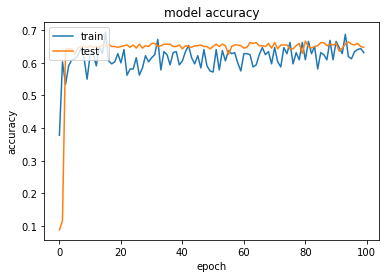

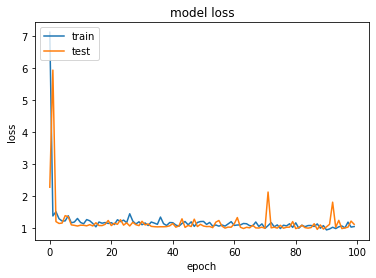

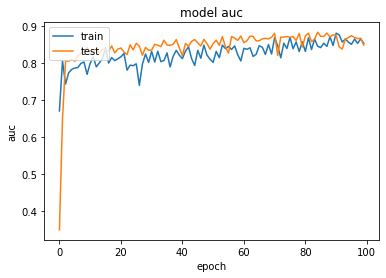

In [34]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for auc
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = baseline_model.predict_generator(valid_generator, valid_generator.samples // valid_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

In [ ]:
preds = []
direc = "../input/cassava-leaf-disease-classification/"
test_direc = direc + "test_images/"
sample_sub_csv = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

for image in sample_sub_csv.image_id:
    img = keras.preprocessing.image.load_img('../input/cassava-leaf-disease-classification/test_images/' + image)
    img = keras.preprocessing.image.img_to_array(img)
    img = keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = baseline_model.predict(img/255)
    preds.append(np.argmax(prediction))

final_submission = pd.DataFrame({'image_id': sample_sub_csv.image_id, 'label': preds})
final_submission.to_csv('submission.csv', index=False) 